In [465]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
from math import floor
import time

b2.defaultclock.dt = 0.10 * b2.ms

In [466]:
start_scope()


N_Excit=384
N_Inhib=96
weight_scaling_factor=5.33
t_stimulus_start=100 * b2.ms
t_stimulus_duration=9999 * b2.ms
coherence_level=0.
stimulus_update_interval=30 * b2.ms
mu0_mean_stimulus_Hz=250.
stimulus_std_Hz=20.
N_extern=1000
firing_rate_extern=9.8 * b2.Hz
w_pos=1.90
f_Subpop_size=0.25  # .15 in publication [1]                     
max_sim_time=1000. * b2.ms 
stop_condition_rate=None
                                
monitored_subset_size=512, 
E_leak_excit = -70.0 * b2.mV

In [450]:
print("simulating {} neurons. Start: {}".format(N_Excit + N_Inhib, time.ctime()))
t_stimulus_end = t_stimulus_start + t_stimulus_duration

N_Group_A = int(N_Excit * f_Subpop_size)  # size of the excitatory subpopulation sensitive to stimulus A
N_Group_B = N_Group_A  # size of the excitatory subpopulation sensitive to stimulus B
N_Group_Z = N_Excit - N_Group_A - N_Group_B  # (1-2f)Ne excitatory neurons do not respond to either stimulus.

Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
G_leak_excit = 25.0 * b2.nS  # leak conductance
E_leak_excit = -90.0 * b2.mV  # reversal potential
v_spike_thr_excit = 50.0 * b2.mV  # spike condition
v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

# specify the inhibitory interneurons:
# N_Inhib = 200
Cm_inhib = 0.2 * b2.nF
G_leak_inhib = 20.0 * b2.nS
E_leak_inhib = -70.0 * b2.mV
v_spike_thr_inhib = -50.0 * b2.mV
v_reset_inhib = -60.0 * b2.mV
t_abs_refract_inhib = 1.0 * b2.ms

# specify the AMPA synapses
E_AMPA = 0.0 * b2.mV
tau_AMPA = 2.5 * b2.ms

# specify the GABA synapses
E_GABA = -70.0 * b2.mV
tau_GABA = 5.0 * b2.ms

# specify the NMDA synapses
E_NMDA = 0.0 * b2.mV
tau_NMDA_s = 100.0 * b2.ms
tau_NMDA_x = 2. * b2.ms
alpha_NMDA = 0.5 * b2.kHz

# projections from the external population
g_AMPA_extern2inhib = 1.62 * b2.nS
g_AMPA_extern2excit = 2.1 * b2.nS

# projectsions from the inhibitory populations
g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

# projections from the excitatory population
g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

# weights and "adjusted" weights.
w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
# We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
# other weights are 1
# print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))A
# Define the inhibitory population

simulating 480 neurons. Start: Wed Oct 26 15:13:23 2022


In [451]:
excit_lif_dynamics = """
        s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
        dv/dt = (
        - G_leak_excit * (v-E_leak_excit)
        - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
        - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
        - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
        )/Cm_excit : volt (unless refractory)
        ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
        ds_GABA/dt = -s_GABA/tau_GABA : 1
        ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
        dx/dt = -x/tau_NMDA_x : 1
    """

In [452]:
one_neuron = NeuronGroup(1, model=excit_lif_dynamics,
                          threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                          refractory=t_abs_refract_excit, method="rk2")

In [453]:
one_neuron.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=excit_pop_A.N) * b2.mV


In [454]:
from brian2 import *



In [455]:


# network parameters
N_E = 1000
gamma = 0.25
N_I = round(gamma * N_E)
N = N_E + N_I
epsilon = 0.1
C_E = epsilon * N_E
C_ext = C_E

# neuron parameters
tau = 10 * ms
theta = 1 * mV
V_r = 0 * mV
tau_rp = 2 * ms

# synapse parameters
J = 0.1 * mV
D = 1.5 * ms
nu_ext = 1 *Hz
# external stimulus
nu_thr = theta / (J * C_E * tau)

defaultclock.dt = 0.1 * ms

Poisson_NE = 1000
g = 1

In [456]:
nu_ext

1. * hertz

In [457]:
# with and without NMDA 와 비교하기 


exc_poisson_input = PoissonInput(
        target=one_neuron, target_var="v", N=N_E, rate=nu_ext, weight=.1*w_pos*mV)

inh_poisson_input = PoissonInput(
        target=one_neuron, target_var="v", N=N_I, rate=nu_ext, weight= -0.1*g*w_neg*mV)

In [458]:
rmp_monitor = StateMonitor(one_neuron, 'v', record = 0)

run(1200*ms, report='text')



Starting simulation at t=0. s for a duration of 1.2 s
1.2 s (100%) simulated in 1s


In [459]:
rmp_monitor.t

<statemonitor.t: array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.1997e+03, 1.1998e+03,
       1.1999e+03]) * msecond>

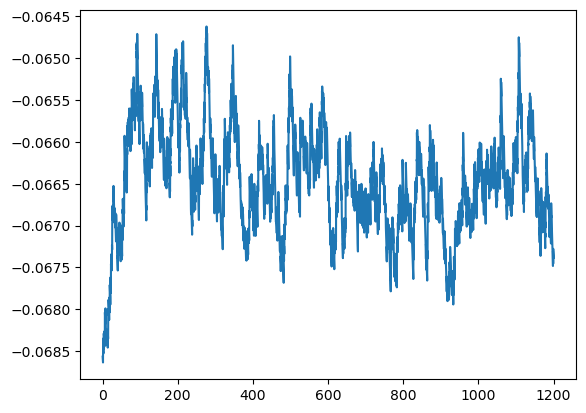

In [460]:
#ylim([-50, 50])

plot(rmp_monitor.t/ms, rmp_monitor.v[0])



In [461]:
nu_thr

10. * hertz

In [462]:
time_in_ms = (rmp_monitor.t/ms)/1000

rmp_in_mV = 1000*(rmp_monitor.v[0])


In [463]:
rmp_in_mV[:10]

array([-68.56619997, -68.57335105, -68.58046646, -68.58754638,
       -68.594591  , -68.60160047, -68.60857499, -68.61551472,
       -68.62241984, -68.62929052]) * volt

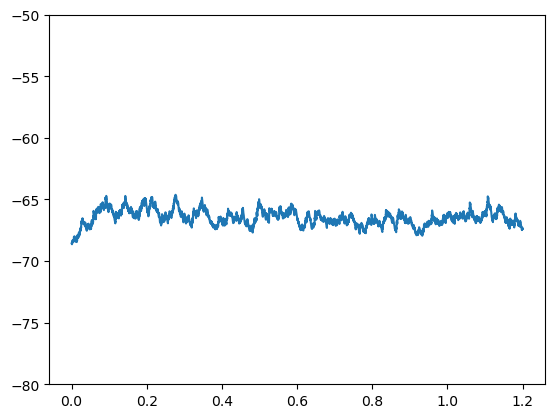

<Figure size 500x100 with 0 Axes>

In [464]:
plt.plot(time_in_ms, rmp_in_mV)

plt.ylim([-80, -50])
plt.figure(figsize=(5,1)) 


plt.show()